# Are MLB players who went to college better than their high school counterparts?

** Investigating a Dataset: A Baseball Project **


Using **Sean Lahman** baseball data (*http://www.seanlahman.com/baseball-archive/statistics/*), I hypothesize that MLB players who attended college were statistically better than those drafted out of high school. My idea is that the additional skill development through college, as well as increased game experience, will lead to more success at the major league level.

Here, I import my code and packages my code uses.

In [1]:
## import my data from local csv files - when running the code, use your own file locations.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## i understand that repetition is an issue
## however, i don't understand how glob works, so this will work for my project.

filename_master = '/Users/Tim/Desktop/Udacity/Data/baseballdatabank-2017.1/core/Master.csv'
master_df = pd.read_csv(filename_master)

filename_college = '/Users/Tim/Desktop/Udacity/Data/baseballdatabank-2017.1/core/CollegePlaying.csv'
college_df = pd.read_csv(filename_college)

filename_allstars = '/Users/Tim/Desktop/Udacity/Data/baseballdatabank-2017.1/core/AllstarFull.csv'
allstars_df = pd.read_csv(filename_allstars)

filename_fielding = '/Users/Tim/Desktop/Udacity/Data/baseballdatabank-2017.1/core/Fielding.csv'
fielding_df = pd.read_csv(filename_fielding)

Because many college players played multiple years and some players in the majors play multiple positions, I sort the data and remove dupicates. I took the most recent college year for college players, and the most frequently-played position for multi-positional players.

In [2]:
## Sort college and fielding data, and remove duplicates

college_df = college_df.sort('yearID', ascending=False).groupby('playerID', as_index=False).first()

fielding_df = fielding_df.sort(['playerID', 'yearID', 'G'], ascending=False).groupby('playerID', as_index=False).first()

/Users/Tim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/Users/Tim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


I plan on merging quite a few datasets, so I set up a few functions to help.

In [3]:
## this formula is to replace nan that appear for players who didn't attend college

def clear_na(merged_df):
    merged_df = merged_df.replace(np.nan, '', regex = True)
    merged_df['college'] = merged_df['schoolID'].astype(bool)
    
    return merged_df


## i created this formula to help merge fielding, allstars and college data, while removing older data

def allstar_merge(allstars_df, college_df, fielding_df):
    merged_df = allstars_df.merge(college_df, on = 'playerID', how = 'left', suffixes = ['_allstar', '_college'])
    merged_df = clear_na(merged_df[merged_df['yearID_allstar'] > 1969])
    merged_df = clear_na(merged_df[merged_df['yearID_allstar'] < 2015])
    merged_df = merged_df.merge(fielding_df[['playerID', 'POS']], on = 'playerID', how = 'left')
    
    return merged_df


# just like above, i created this formula to help with merging the master set, fielding and college data.
# i also parsed the debut date to isolate debut year for players.

def master_merge(master_df, college_df, fielding_df):
    master_college_df = master_df.merge(college_df, on = 'playerID', how = 'left', suffixes = ['_master', '_college'])
    master_college_df['debut_year'] = pd.to_numeric(clear_na(master_college_df).loc[:,'debut'].astype(str).str[:4])
    master_college_df = master_college_df[master_college_df['debut_year'] > 1969]
    master_college_df = master_college_df[master_college_df['debut_year'] < 2015]
    master_college_df = master_college_df.merge(fielding_df[['playerID', 'POS']], on = 'playerID', how = 'left')
    master_college_df['college'] = master_college_df['schoolID'].astype(bool)
    
    return clear_na(master_college_df)
    

The merging begins:

In [4]:
# merging using the formulas

allstar_college_df = allstar_merge(allstars_df, college_df, fielding_df)
master_college_df = master_merge(master_df, college_df, fielding_df)

# delete allstar position, as we added a more reliable position set

del allstar_college_df['startingPos']

I then printed some numbers to briefly see how many all stars went to college, compared to total major league players.

In [5]:
# sum the allstar players who did and didn't go to college

allstar_college = sum(allstar_college_df['college'])

print "MLB All Stars & College, since 1969:\n", "\nNumber attended: ", allstar_college
print "Number who didn't:", len(allstar_college_df) - allstar_college

MLB All Stars & College, since 1969:

Number attended:  1184
Number who didn't: 1684


In [6]:
# sum the MLB players who did and didn't go to college

master_college = sum(master_college_df['college'])

print "MLB Players & College, since 1969:\n", "\nNumber attended: ", master_college
print "Number who didn't:", len(master_college_df) - master_college

MLB Players & College, since 1969:

Number attended:  4231
Number who didn't: 3611


Interesting. Now, I decide to plot the percentage of all stars and major leaguers who went to college, per year. I chose to start in 1970, as that is when the last major change to MLB rules occurred (the lowering of the mound). I ended the investigation in 2014, as the data doesn't cover 2015 and 2016 college graduates.

In [7]:
## NOTE : cannot run this code multiple times. rerun entire code to repeat this section.

allstar_year_mean = allstar_college_df.groupby('yearID_allstar').mean() * 100

del allstar_year_mean['gameNum']
del allstar_year_mean['GP']

Populating the interactive namespace from numpy and matplotlib


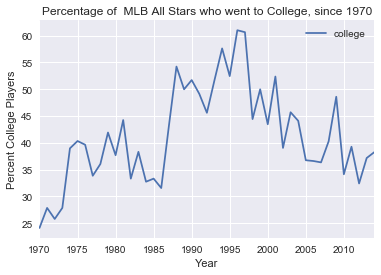

In [8]:
# plot percentage of allstar players who attended college

%pylab inline
allstar_year_mean.plot()
plt.xlabel("Year")
plt.ylabel("Percent College Players")
plt.title("Percentage of  MLB All Stars who went to College, since 1970")

Populating the interactive namespace from numpy and matplotlib


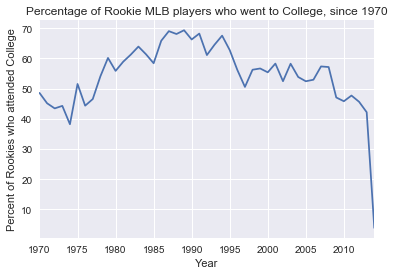

In [9]:
# plot percentage of MLB players who attended college

master_year_mean = master_college_df.groupby('debut_year').mean() * 100

%pylab inline
master_year_mean['college'].plot()
plt.xlabel("Year")
plt.ylabel("Percent of Rookies who attended College")
plt.title("Percentage of Rookie MLB players who went to College, since 1970")

After investigating those plots, I chose to combine them onto one plot. I borrowed code I found on a forum, and posted the link in a comment. 

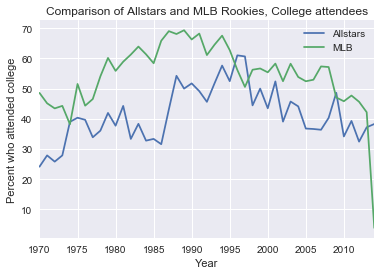

In [10]:
# plot both MLB and allstar players who attended college, on the same graph, using help from this code:
# https://stackoverflow.com/questions/17812978/how-to-plot-two-columns-of-a-pandas-data-frame-using-points

import numpy as np
import pandas as pd

d = {'MLB' : master_year_mean['college'],
     'Allstars' : allstar_year_mean['college']}

df = pd.DataFrame(d)
df.plot()
plt.xlabel('Year')
plt.ylabel('Percent who attended college')
plt.title('Comparison of Allstars and MLB Rookies, College attendees')

Almost every year had the percentage of MLB players who went to college higher than the percentage of all stars who went to college. Now, I wonder if it can break down position by position:

In [11]:
# isolate player positons for MLB and check the quality of the data

master_positions = pd.concat([master_college_df, pd.get_dummies(master_college_df['POS'])], axis = 1)
master_positions = master_positions.groupby('debut_year').sum()

master_positions['1B'].head()

debut_year
1970.0    11
1971.0    10
1972.0     9
1973.0    14
1974.0    16
Name: 1B, dtype: uint8

In [12]:
# isolate all star positions and check the quality of the data

allstar_positions = pd.concat([allstar_college_df, pd.get_dummies(allstar_college_df['POS'])], axis = 1)
allstar_positions = allstar_positions.groupby('yearID_allstar').sum()

allstar_positions['1B'].head()

yearID_allstar
1970    17
1971    14
1972    11
1973    12
1974    12
Name: 1B, dtype: uint8

Something is wrong with my data or data management. There shouldn't be more all stars at a single position than in MLB any year. On top of that, there should be 28 or more first basemen (or any position) as there have been 28 or more teams in baseball since before 1970. I am going to ignore the positions, though it would have been interesting to see if there was a college-attendee increase for certain positions.

Perhaps Allstar players merely are physically different than major league players. Now, let's look at the height distributions for MLB and Allstars.

In [13]:
# to look at allstar player heights, merge from the MLB dataframe the heights into the allstar data frame

allstar_college_df = allstar_college_df.merge(master_college_df[['playerID','height']], on = 'playerID', how = 'left')

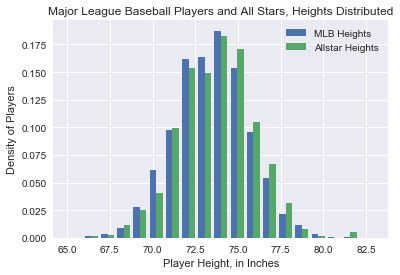

In [14]:
# form a new dataframe of the heights from MLB and allstars, and then compare on a histogram
# i normalized the data for clear comparison

heights = [master_college_df['height'], allstar_college_df['height']]
plt.hist(heights, normed = True, bins = 19)
plt.legend(['MLB Heights', 'Allstar Heights'])
plt.xlabel('Player Height, in Inches')
plt.ylabel('Density of Players')
plt.title('Major League Baseball Players and All Stars, Heights Distributed')

As seen in the plot above, Allstar players tend to be taller than their MLB counterparts. The Allstar distribution is greater than the MLB distribution for taller heights, and lower for smaller heights - meaning that more Allstars tend to be taller and fewer tend to be shorter compared to MLB average.

# Conclusion

** Limitations **

Some of the difficulties I faced on this project were my lack of coding experience and incomplete data. I have data analysis experience through R but not python, so I am learning how to code through these projects. Much of the data I wanted to use, such as fielding positions, is incomplete the further in the past I went. This limited both the time frame and factors of study. The time this project took was greater than I anticipated, as well, taking close to 10 hours to complete (which much was learning certain code syntax or troubleshooting issues).

** Results **

As seen in the above plots, a Major League All Star is less likely to be a college graduate than the average major leaguer and is more likely to be taller. Intuitively, both results makes sense (even though I didn't expect it). For college players, one train of though is that if a player is extremely skilled, he is most likely to be drafted as soon as he is eligible, which is after high school. The most skilled players become all star players. Those who aren't as skilled will go through college to enhance their skills, likely to not become all stars. Taller players are likely to be larger, stronger and throw and swing harder, all increasing their skill and chances of becoming an allstar. 




*note: this study is not comprehensive and does not use the proper statistical techniques. This study is merely and inquiry that could lead to further research.*